In [2]:
import os
import os.path
#abspath = os.path.abspath(__file__)
#dname = os.path.dirname(abspath)
#os.chdir(dname)
import rrsBdtDevDependencies
import dataFunctions as dataFun
from datetime import datetime as dt

In [3]:
### CONFIGURE ###
barrels = 750000
costPerDay = 30000
days = 1
trainDataDate = '2018-01-01'

In [4]:
print('Running...')

def show_more(df, lines):
    with pd.option_context("display.max_rows", lines):
        display(df)

Running...


In [5]:
import quandl
wtiData = quandl.get("FRED/DCOILWTICO")

In [6]:
wtiData.reset_index(level=0, inplace=True)
wtiData = wtiData.rename(columns={"Value": "Prices"})
wtiData.head()

,Date,Prices
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [7]:
import yfinance as yf

yfStartDate = wtiData['Date'].iloc[-1].strftime('%Y-%m-%d')
stocks = "CL=F"
period = "1d"
Stocks, yfInfo = dataFun.yFinData(yfStartDate)

wtiData = wtiData.append(Stocks, ignore_index =True)
wtiData = wtiData.sort_values(by = ["Date"])

[*********************100%***********************]  1 of 1 completed


In [8]:
import numpy as np
oilDF = dataFun.oilProduction()

df = dataFun.combineFrames(wtiData,oilDF)
df = df[np.isfinite(df['Prices'])]
df = df.reset_index().drop(["index"], axis = 1)
df

,Date,Prices,Production of Crude Oil
0,1986-01-03,26.000000,8942.0
1,1986-01-06,26.530000,8942.0
2,1986-01-07,25.850000,8942.0
3,1986-01-08,25.870000,8942.0
4,1986-01-09,26.030000,8942.0
...,...,...,...
8580,2020-01-16,58.599998,13000.0
8581,2020-01-17,58.810001,13000.0
8582,2020-01-19,59.250000,13000.0
8583,2020-01-21,58.250000,13000.0


In [9]:
natGasData = quandl.get("EIA/NG_RNGWHHD_D")
natGasData.reset_index(level=0, inplace=True)
natGasData = natGasData.rename(columns={"Value": "NatGasPrices"})

yfStartDate = natGasData['Date'].iloc[-1].strftime('%Y-%m-%d')
stocks = "NG=F"
period = "1d"
NGStocks, yfInfo = dataFun.yFinData(yfStartDate,stock=stocks,name ="NatGasPrices")
natGasData = natGasData.append(NGStocks, ignore_index =True)
natGasData = natGasData.sort_values(by = ["Date"])
natGasData

[*********************100%***********************]  1 of 1 completed


,Date,NatGasPrices
0,1997-01-07,3.820
1,1997-01-08,3.800
2,1997-01-09,3.610
3,1997-01-10,3.920
4,1997-01-13,4.000
...,...,...
5799,2020-01-16,2.068
5800,2020-01-17,2.003
5801,2020-01-19,1.903
5802,2020-01-21,1.917


In [10]:
import pandas as pd
newdf = pd.merge(df, natGasData, on=['Date'], how ="left")
newdf.head()

,Date,Prices,Production of Crude Oil,NatGasPrices
0,1986-01-03,26.00,8942.0,NaN
1,1986-01-06,26.53,8942.0,NaN
2,1986-01-07,25.85,8942.0,NaN
3,1986-01-08,25.87,8942.0,NaN
4,1986-01-09,26.03,8942.0,NaN


In [71]:
brentData = quandl.get("FRED/DCOILBRENTEU")
brentData.reset_index(level=0, inplace=True)
name = "BrentPrices"
brentData = brentData.rename(columns={"Value": name})

yfStartDate = brentData['Date'].iloc[-1].strftime('%Y-%m-%d')
stocks = "BZ=F"
period = "1d"
BStocks, yfInfo = dataFun.yFinData(yfStartDate,stock=stocks,name = name)
brentData = brentData.append(BStocks, ignore_index =True)
brentData = brentData.sort_values(by = ["Date"])
brentData

[*********************100%***********************]  1 of 1 completed


,Date,BrentPrices
0,1987-05-20,18.630000
1,1987-05-21,18.450000
2,1987-05-22,18.550000
3,1987-05-25,18.600000
4,1987-05-26,18.630000
...,...,...
8292,2020-01-20,64.630000
8293,2020-01-21,63.660000
8294,2020-01-21,64.550003
8295,2020-01-22,62.759998


In [12]:
df = pd.merge(newdf, brentData, on=['Date'], how ="left")
df = df[df["Date"] > trainDataDate]
df = df.rename(columns={"Production of Crude Oil": "OilProduction"})
df.isna().sum()


Date             0
Prices           0
OilProduction    0
NatGasPrices     1
BrentPrices      4
dtype: int64

In [13]:
df["BrentPrices"] = df["BrentPrices"].interpolate(method='nearest')
df["NatGasPrices"] = df["NatGasPrices"].interpolate(method='nearest')
df.isna().sum()

Date             0
Prices           0
OilProduction    0
NatGasPrices     0
BrentPrices      0
dtype: int64

In [14]:
df = df.reset_index().drop(["index"], axis = 1)
df["20dSMA"] = dataFun.SMA(20, df["Prices"])
df["10dSMA"] = dataFun.SMA(10, df["Prices"])
df["5dSMA"] = dataFun.SMA(5, df["Prices"])
df["50dSMA"] = dataFun.SMA(50, df["Prices"])
df["200dSMA"] = dataFun.SMA(200, df["Prices"])


df["boll_lo"] = dataFun.bollinger(df['Prices'])[0]
df["boll_hi"] = dataFun.bollinger(df['Prices'])[1]

df = dataFun.momentum(df, 14)
df = dataFun.macd(df, 12, 26)
df = dataFun.rate_of_change(df, 14)
df = dataFun.relative_strength_index(df)

df["boll_hi"] = pd.to_numeric(df["boll_hi"])
df["boll_lo"] = pd.to_numeric(df["boll_lo"])
df["20dSMA"] = pd.to_numeric(df["20dSMA"])
df["10dSMA"] = pd.to_numeric(df["10dSMA"])
df["5dSMA"] = pd.to_numeric(df["5dSMA"])
df["50dSMA"] = pd.to_numeric(df["50dSMA"])
df["200dSMA"] = pd.to_numeric(df["200dSMA"])

df["bollAmplitude"] = df["boll_hi"] - df["boll_lo"]
df["distFromTopBoll"] = df["boll_hi"] - df["Prices"]
df["distFromLowBoll"] = df["boll_lo"] - df["Prices"]
df["20d200dDist"] = np.abs(df["20dSMA"] - df["200dSMA"])
df

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
0,2018-01-02,60.370000,9782.0,6.240,66.650000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,61.610000,9782.0,6.240,67.850000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,61.980000,9782.0,4.650,68.730000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,61.490000,9492.0,4.650,68.010000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,61.730000,9492.0,2.890,68.480000,NaN,NaN,61.436000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,2020-01-16,58.599998,13000.0,2.068,64.769997,59.5625,58.191001,58.228001,59.0850,57.64795,...,-4.100002,-0.440216,-0.254094,-0.186123,-0.017603,6.041469,7.461788,4.693396,-2.768392,1.91455
517,2020-01-17,58.810001,13000.0,2.003,65.089996,59.4200,58.255001,58.364001,59.1236,57.61890,...,-0.839999,-0.393453,-0.281966,-0.111488,-0.012592,-13.718479,7.218607,4.219302,-2.999304,1.80110
518,2020-01-19,59.250000,13000.0,1.903,65.709999,59.3255,58.363001,58.588000,59.1772,57.59710,...,-0.310000,-0.317232,-0.289019,-0.028213,0.003897,-1.540174,7.034979,3.592990,-3.441989,1.72840
519,2020-01-21,58.250000,13000.0,1.917,64.550003,59.1795,58.371001,58.608000,59.1914,57.56905,...,-0.770000,-0.333672,-0.297949,-0.035722,0.001375,2.912824,6.873208,4.366105,-2.507104,1.61045


In [15]:
df = df[np.isfinite(df['200dSMA'])]
df.isna().sum()

Date               0
Prices             0
OilProduction      0
NatGasPrices       0
BrentPrices        0
20dSMA             0
10dSMA             0
5dSMA              0
50dSMA             0
200dSMA            0
boll_lo            0
boll_hi            0
Momentum_14        0
MACD_12_26         0
MACDsign_12_26     0
MACDdiff_12_26     0
ROC_14             0
RSI_14             0
bollAmplitude      0
distFromTopBoll    0
distFromLowBoll    0
20d200dDist        0
dtype: int64

In [16]:
df = df.drop_duplicates("Date",keep="first")
df

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
199,2018-10-16,71.930000,10900.0,3.270,80.530000,73.0510,73.365000,71.866000,70.1724,67.33960,...,-0.290000,0.544398,0.990059,-0.445661,-0.003464,4.112887,6.809132,4.525566,-2.283566,5.71140
200,2018-10-17,69.630000,10900.0,3.300,79.910000,72.9785,72.688000,71.156000,70.1816,67.38590,...,-2.550000,0.260303,0.844108,-0.583805,-0.048250,1.756679,7.270465,6.983733,-0.286733,5.59260
201,2018-10-18,68.630000,10900.0,3.280,80.300000,72.8715,72.107000,70.688000,70.2158,67.42100,...,-4.530000,-0.045017,0.666283,-0.711300,-0.089426,1.548427,8.030146,8.256573,0.226427,5.45050
202,2018-10-19,69.160000,10900.0,3.200,80.380000,72.7895,71.597000,70.238000,70.2628,67.45690,...,-6.210000,-0.241436,0.484739,-0.726175,-0.079830,1.861776,8.506270,7.882635,-0.623635,5.33260
203,2018-10-22,69.250000,10900.0,3.200,80.450000,72.5905,71.095000,69.720000,70.2956,67.49570,...,-5.910000,-0.385395,0.310712,-0.696107,-0.093586,1.938645,9.059592,7.870296,-1.189296,5.09480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,2020-01-16,58.599998,13000.0,2.068,64.769997,59.5625,58.191001,58.228001,59.0850,57.64795,...,-4.100002,-0.440216,-0.254094,-0.186123,-0.017603,6.041469,7.461788,4.693396,-2.768392,1.91455
517,2020-01-17,58.810001,13000.0,2.003,65.089996,59.4200,58.255001,58.364001,59.1236,57.61890,...,-0.839999,-0.393453,-0.281966,-0.111488,-0.012592,-13.718479,7.218607,4.219302,-2.999304,1.80110
518,2020-01-19,59.250000,13000.0,1.903,65.709999,59.3255,58.363001,58.588000,59.1772,57.59710,...,-0.310000,-0.317232,-0.289019,-0.028213,0.003897,-1.540174,7.034979,3.592990,-3.441989,1.72840
519,2020-01-21,58.250000,13000.0,1.917,64.550003,59.1795,58.371001,58.608000,59.1914,57.56905,...,-0.770000,-0.333672,-0.297949,-0.035722,0.001375,2.912824,6.873208,4.366105,-2.507104,1.61045


In [17]:
df = df[df["Date"] > trainDataDate]
df = df.reset_index().drop(["index"], axis = 1)
df

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
0,2018-10-16,71.930000,10900.0,3.270,80.530000,73.0510,73.365000,71.866000,70.1724,67.33960,...,-0.290000,0.544398,0.990059,-0.445661,-0.003464,4.112887,6.809132,4.525566,-2.283566,5.71140
1,2018-10-17,69.630000,10900.0,3.300,79.910000,72.9785,72.688000,71.156000,70.1816,67.38590,...,-2.550000,0.260303,0.844108,-0.583805,-0.048250,1.756679,7.270465,6.983733,-0.286733,5.59260
2,2018-10-18,68.630000,10900.0,3.280,80.300000,72.8715,72.107000,70.688000,70.2158,67.42100,...,-4.530000,-0.045017,0.666283,-0.711300,-0.089426,1.548427,8.030146,8.256573,0.226427,5.45050
3,2018-10-19,69.160000,10900.0,3.200,80.380000,72.7895,71.597000,70.238000,70.2628,67.45690,...,-6.210000,-0.241436,0.484739,-0.726175,-0.079830,1.861776,8.506270,7.882635,-0.623635,5.33260
4,2018-10-22,69.250000,10900.0,3.200,80.450000,72.5905,71.095000,69.720000,70.2956,67.49570,...,-5.910000,-0.385395,0.310712,-0.696107,-0.093586,1.938645,9.059592,7.870296,-1.189296,5.09480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2020-01-16,58.599998,13000.0,2.068,64.769997,59.5625,58.191001,58.228001,59.0850,57.64795,...,-4.100002,-0.440216,-0.254094,-0.186123,-0.017603,6.041469,7.461788,4.693396,-2.768392,1.91455
311,2020-01-17,58.810001,13000.0,2.003,65.089996,59.4200,58.255001,58.364001,59.1236,57.61890,...,-0.839999,-0.393453,-0.281966,-0.111488,-0.012592,-13.718479,7.218607,4.219302,-2.999304,1.80110
312,2020-01-19,59.250000,13000.0,1.903,65.709999,59.3255,58.363001,58.588000,59.1772,57.59710,...,-0.310000,-0.317232,-0.289019,-0.028213,0.003897,-1.540174,7.034979,3.592990,-3.441989,1.72840
313,2020-01-21,58.250000,13000.0,1.917,64.550003,59.1795,58.371001,58.608000,59.1914,57.56905,...,-0.770000,-0.333672,-0.297949,-0.035722,0.001375,2.912824,6.873208,4.366105,-2.507104,1.61045


In [54]:
def create_features(df, label=None, shift = 0):
    """
    Creates time series features from datetime index
    """
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    df = df.set_index('Date')
    #X = df[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']]

    X = df[['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']]
    if shift > 0:
        tiems = X[['dayofyear','dayofmonth','weekofyear']]
        #X = X[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26','ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist']].shift(shift)
        X = X[['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26','ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist']].shift(shift)
        X = X.merge(tiems, how='inner', left_index=True, right_index=True)

    if label:
        y = df[label]
        return X, y
    return X

In [55]:
testSplitDate = '2020-01-01'
df_train = df[df["Date"] <= testSplitDate].copy()
df_test = df[df["Date"] > testSplitDate].copy()

X_train, y_train = create_features(df_train, label='Prices', shift =1)
X_test, y_test = create_features(df_test, label='Prices', shift =1)
X_train = X_train.iloc[1:]
X_test = X_test.iloc[1:]
y_train = y_train.iloc[1:]
y_test = y_test.iloc[1:]

In [56]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
plt.style.use('fivethirtyeight')

model = XGBRegressor(
    n_estimators=1000,
    #max_depth=8,
    #min_child_weight=300, 
    #colsample_bytree=0.8, 
    #subsample=0.8, 
    #eta=0.3,    
    #seed=42
    )

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False, 
    early_stopping_rounds = 100)

[09:11:08] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [57]:
model.feature_importances_

array([0.01424654, 0.2319408 , 0.07274668, 0.20754305, 0.01126176,
       0.07764263, 0.01343076, 0.01265956, 0.10496183, 0.03455766,
       0.16390982, 0.03725445, 0.01113461, 0.00670976], dtype=float32)

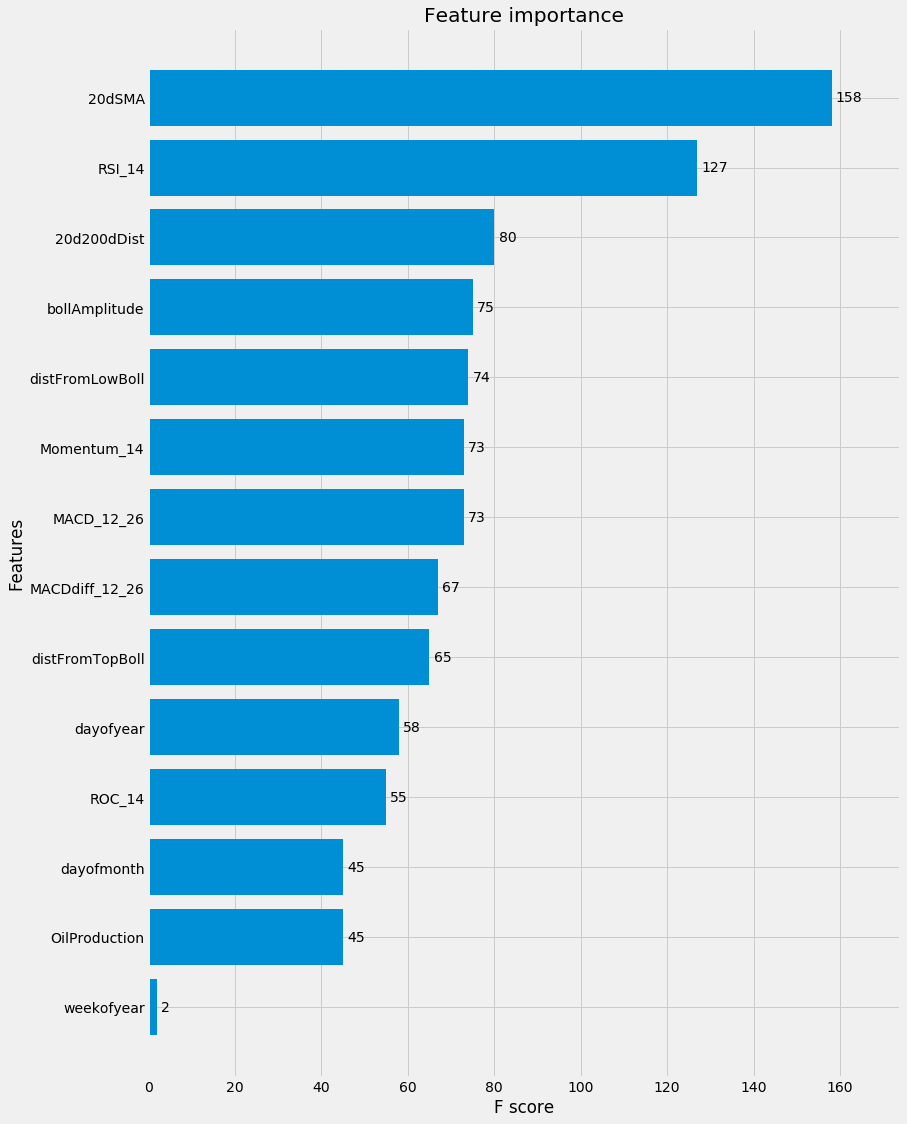

In [58]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

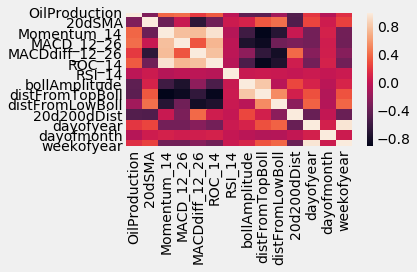

In [59]:
correl = X_train.corr()
sns.heatmap(correl, xticklabels=correl.columns, yticklabels=correl.columns)
plt.tight_layout()
plt.show()

In [60]:
correl

,OilProduction,20dSMA,Momentum_14,MACD_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist,dayofyear,dayofmonth,weekofyear
OilProduction,1.000000,-0.298547,0.386592,0.411441,0.209148,0.339549,-0.029756,-0.446837,-0.462021,-0.149613,-0.498769,0.195944,-0.057089,0.160674
20dSMA,-0.298547,1.000000,-0.385004,0.026007,-0.689933,-0.365744,0.045778,0.098955,0.327969,0.423143,-0.516469,0.255421,0.052377,0.243439
Momentum_14,0.386592,-0.385004,1.000000,0.779846,0.764956,0.952221,-0.058742,-0.593858,-0.914353,-0.717895,0.031996,-0.346733,0.090280,-0.359014
MACD_12_26,0.411441,0.026007,0.779846,1.000000,0.316263,0.737421,-0.023926,-0.760792,-0.850336,-0.364815,-0.315276,-0.349188,0.059858,-0.368027
MACDdiff_12_26,0.209148,-0.689933,0.764956,0.316263,1.000000,0.785926,-0.026208,-0.229362,-0.662487,-0.811928,0.401691,-0.263002,0.069917,-0.266099
ROC_14,0.339549,-0.365744,0.952221,0.737421,0.785926,1.000000,-0.047562,-0.534280,-0.883176,-0.750534,0.059065,-0.347053,0.088951,-0.358332
RSI_14,-0.029756,0.045778,-0.058742,-0.023926,-0.026208,-0.047562,1.000000,0.024883,0.039955,0.032920,0.008023,0.041514,0.010491,0.040812
bollAmplitude,-0.446837,0.098955,-0.593858,-0.760792,-0.229362,-0.534280,0.024883,1.000000,0.815988,-0.041949,0.263585,0.100669,-0.039264,0.108925
distFromTopBoll,-0.462021,0.327969,-0.914353,-0.850336,-0.662487,-0.883176,0.039955,0.815988,1.000000,0.543330,0.077794,0.298182,-0.072063,0.311477
distFromLowBoll,-0.149613,0.423143,-0.717895,-0.364815,-0.811928,-0.750534,0.032920,-0.041949,0.543330,1.000000,-0.248343,0.369170,-0.067529,0.380159


In [80]:
df_test = df_test.iloc[1:]
df_train = df_train.iloc[1:]
df_test['WTI_Prediction'] = model.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)
df_all = df_all.set_index("Date")
_ = df_all[df_all.index > '2019-11-01'][['Prices','WTI_Prediction']].plot(figsize=(15, 5))

ValueError: Length of values does not match length of index

In [78]:
X_new = df[df["Date"]>'2020-01-21'].copy()
X_new = create_features(X_new)
X_new


,OilProduction,20dSMA,Momentum_14,MACD_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,
2020-01-22,13000.0,58.837,-2.019998,-0.51027,-0.169857,-0.034726,1.364506,6.37985,5.876924,-0.502926,1.30435,22,22,4


In [79]:
new_pred = model.predict(X_new)
new_pred

array([56.163315], dtype=float32)

In [63]:
df["Prices"].iloc[-1]

56.150001525878906

In [64]:
new_pred > df["Prices"].iloc[-1]

array([ True])

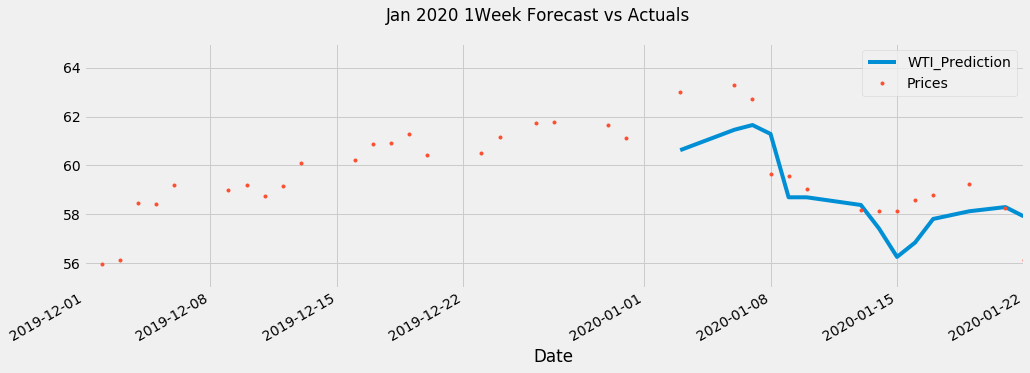

In [73]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['WTI_Prediction','Prices']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='2019-12-01', upper='2020-01-22')
ax.set_ylim(55, 65)
plot = plt.suptitle('Jan 2020 1Week Forecast vs Actuals')

In [66]:
mean_squared_error(y_true=df_test['Prices'],
                   y_pred=df_test['WTI_Prediction'])

1.860563663554027

In [67]:

testSplitDate = '2020-01-21'
fin_df_train = df[df["Date"] <= testSplitDate].copy()
fin_df_test = df[df["Date"] > testSplitDate].copy()

X_train, y_train = create_features(fin_df_train, label='Prices')
X_test, y_test = create_features(fin_df_test, label='Prices')

model = XGBRegressor(
    n_estimators=1000,
    #max_depth=8,
    #min_child_weight=300, 
    #colsample_bytree=0.8, 
    #subsample=0.8, 
    #eta=0.3,    
    #seed=42
    )

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False, 
    early_stopping_rounds = 100)

[09:12:25] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [68]:
from sklearn.externals import joblib

modDate = str(fin_df_train["Date"].iloc[-1].strftime('%Y-%m-%d'))
filename = 'finalized_model_'+modDate+'.sav'
joblib.dump(model, filename)

['finalized_model_2020-01-21.sav']

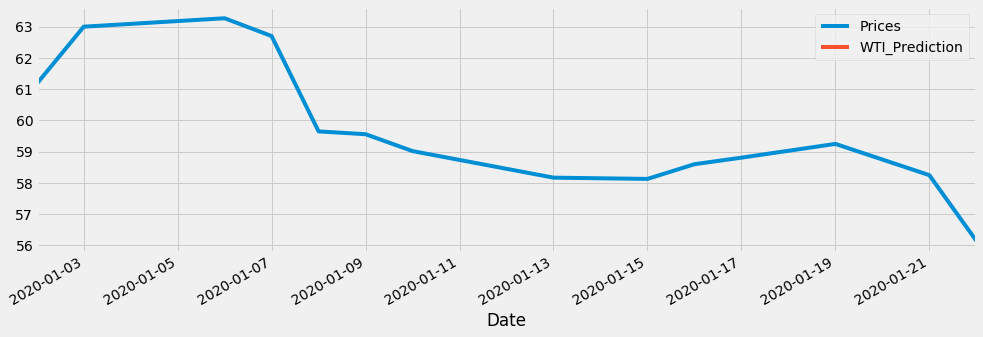

In [69]:
fin_df_test['WTI_Prediction'] = model.predict(X_test)
fin_df_all = pd.concat([fin_df_test, fin_df_train], sort=False)
fin_df_all = fin_df_all.set_index("Date")
_ = fin_df_all[fin_df_all.index > '2020-01-01'][['Prices','WTI_Prediction']].plot(figsize=(15, 5))

In [70]:
fin_df_test

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,WTI_Prediction
314,2020-01-22,56.150002,13000.0,1.917,62.759998,58.837,58.173001,58.212,59.178,57.53265,...,-0.502926,1.30435,2,1,1,2020,22,22,4,56.163315


,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
0,2018-01-02,60.370000,9782.0,6.240,66.650000,57.9825,58.923,59.978000,56.6008,50.45180,...,2.530000,1.008636,0.787402,0.221234,0.056898,-0.380868,5.343712,0.284356,-5.059356,7.53070
1,2018-01-03,61.610000,9782.0,6.240,67.850000,58.1890,59.367,60.390000,56.8004,50.51815,...,4.490000,1.143123,0.858546,0.284577,0.088708,-0.212073,6.221374,-0.310313,-6.531687,7.67085
2,2018-01-04,61.980000,9782.0,4.650,68.730000,58.4050,59.816,60.852000,57.0018,50.58910,...,5.390000,1.264980,0.939833,0.325147,0.087368,-0.183997,7.055957,-0.047022,-7.102978,7.81590
3,2018-01-05,61.490000,9492.0,4.650,68.010000,58.6900,60.156,61.182000,57.1852,50.66145,...,4.490000,1.306947,1.013256,0.293691,0.073311,-0.484253,7.118604,0.759302,-6.359302,8.02855
4,2018-01-08,61.730000,9492.0,2.890,68.480000,58.9515,60.495,61.436000,57.3804,50.73365,...,4.440000,1.344079,1.079421,0.264659,0.079762,-0.423550,7.298384,0.870692,-6.427692,8.21785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2020-01-06,62.820000,12900.0,2.153,68.500000,62.0015,62.853,62.910000,59.3420,57.95040,...,1.650000,1.106829,1.195437,-0.088609,0.017822,-1.128475,4.112569,1.237785,-2.874784,4.05110
509,2020-01-07,64.779999,12900.0,2.149,70.860001,62.1965,63.214,63.212000,59.5168,57.97335,...,3.059999,1.206315,1.197613,0.008703,0.048899,-0.216197,4.659907,-0.253545,-4.913452,4.22315
510,2020-01-08,59.950001,12900.0,2.155,65.739998,62.1475,62.909,62.638000,59.5892,57.96515,...,-1.809999,0.885215,1.135133,-0.249918,-0.027733,1.936502,4.957161,4.676080,-0.281081,4.18235
511,2020-01-09,59.529999,12900.0,2.166,65.309998,62.0590,62.535,61.980000,59.6390,57.95015,...,-2.130001,0.590048,1.026116,-0.436068,-0.026333,1.795266,5.441159,5.249581,-0.191578,4.10885
